# Imports

In [321]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import random
%run "bn_utils.ipynb"

In [322]:
IN_PATH = ".\inputs"
OUT_PATH = ".\outputs"

# Exact Inference (Don't change this cell)

In [323]:
def exact_inference(query, evidence, cpts, graph):
    new_cpts = []
    parents = graph['parents_nodes']
    for i, cpt in enumerate(cpts):
        tb = []
        for row in cpt:
            if evidence.get(i) and evidence[i] != row[i]:
                continue
            flag = True
            for j in parents[i]:
                if evidence.get(j) and row[j] != evidence[j]:
                    flag = False
            if flag:
                tb.append(row)
        new_cpts.append(tb)
    return variable_elimination(evidence, query, new_cpts)

# Loading Model
You should read the bayesian network from the *path* and output:
1. conditional probability tables (CPTs) [list of list of dictionary]
    - each member (cpt) is a list (the list at index *i* is cpt of vertex *i* )
    - each member of cpt is a dictionary:
        - the dictionary contains *|parents(v)| + 2* keys. (the value of parents of *v*, the value of *v* and *'prob'*)
        - e.g:
            *{
                V<sub>1</sub>: True,
                V<sub>2</sub>: False,
                ...
                V<sub>v</sub>: True,
                'prob': 0.66
            }*
<br/><br/>
2. graph (bayesian network) [dictionary of list of list]
    - the keys are *'parents_nodes'* and *'children_nodes'*
    - the value of each key is a list of list; the element at index *i* is the parents/children of vertex *i*
<br/><br/>
3. V (the number of variables/vertexes) [integer]

In [324]:
def load_model(path):
    V = 0
    lines = []
    map_name_number = {}
    cnt = 0
    with open(path, 'r') as file:
        lines = [line.strip() for line in file]



    for i, line in enumerate(lines):
        if i == 0:
            V = int(line)
            continue

        words = line.split()

        if len(words) == 1 and words[0].isalpha() and words[0] not in map_name_number:
            map_name_number[words[0]] = cnt
            cnt += 1

    global map_vertex
    map_vertex = map_name_number

    graph = {
        'parents_nodes': [[] for _ in range(V)],
        'children_nodes': [[] for _ in range(V)]
    }
    parents = []
    cpts = []
    cpt = []
    node = {}
    current = ""
    

    for k, line in enumerate(lines):
        if k == 0:
            continue

        words = line.split()

        if len(words) == 1 and (not (words[0].isalpha() and len(lines[k - 1].split()) == 1 and lines[k - 1].split()[0].isalpha())):
            if words[0].isalpha():
                current = words[0]
                if cpt:
                    cpts.append(cpt)
                cpt = []
                parents = []
            else:
                _cpt = []
                probability = float(words[0])
                node = {map_name_number[current]: True, 'Prob': probability}
                _cpt.append(node)
                node = {map_name_number[current]: False, 'Prob': 1 - probability}
                _cpt.append(node)
                cpts.append(_cpt)

        else:
            if all(word.isalpha() for word in words):
                parents = words
            else:
                parents_status = [(parents[j], words[j] == '1') for j in range(len(parents))]

                node = {map_name_number[current]: True}
                for k, (p, s) in enumerate(parents_status):
                    node[map_name_number[p]] = s
                    graph['children_nodes'][map_name_number[p]].append(map_name_number[current])
                    graph['children_nodes'][map_name_number[p]] = list(set(graph['children_nodes'][map_name_number[p]]))
                    graph['parents_nodes'][map_name_number[current]].append(map_name_number[p])
                    graph['parents_nodes'][map_name_number[current]] = list(set(graph['parents_nodes'][map_name_number[current]]))

                node['Prob'] = float(words[-1])
                cpt.append(node)

                node = {map_name_number[current]: False}
                for k, (p, s) in enumerate(parents_status):
                    node[map_name_number[p]] = s

                node['Prob'] = 1 - float(words[-1])
                cpt.append(node)

    if cpt:
        cpts.append(cpt)

    return cpts, graph, V

# Approximate Inference

### Prior Sampling

You should implement Prior Sampling.

1. First, sort the vertices topologically (We have done this for you; you just need to call the *topological_sort* function)

2. Sample each vertex in topological order
    - You can use np.random.random() function to generate a random number between 0 and 1
        - To propose, the *sample_vertex* function which is defined in *bn_utils* file, can be useful
<br/><br/>

3. Take enough samples from the whole bayes net, say 10000

4. Calculate the approximate probability of the query respecting to the evidence.
    - Calculate # of samples that are consistent with the evidence
    - Calculate # of samples that the query and the evidence occurred at the same time
    - The conditional probability is obtained by dividing the first item by the second

>Notice how this wouldn't work when we don't have samples that are consistent with evidence.
<br/><br/>

**Feel free to use each function in the *bn_utils* file whenever you need**

In [325]:
def prior_sample(query, evidence, cpts, graph, num_samples):
    topological_order = topological_sort(graph)
    consistent_sample = 0
    query_and_evidence = 0
    for _ in range(num_samples):
        sampled_values = {node: -1 for node in range(len(graph['children_nodes']))}

        for vertex in topological_order:
            sampled_values[vertex] = sample_vertex(vertex, sampled_values, cpts)

        if all(sampled_values[node] == value for node, value in evidence.items()):
            consistent_sample = consistent_sample + 1
            
            if all(sampled_values[node] == value for node, value in query.items()):
                query_and_evidence = query_and_evidence + 1

    return query_and_evidence / consistent_sample if consistent_sample> 0 else 0


### Rejection Sampling

This is almost identical to Prior Sampling except that we reject samples that are inconsistent with the evidence.

1. First, sort the vertices topologically (Done for you! you just need to call the *topological_sort* function)

2. Sample each vertex in topological order
    - You can use np.random.random() function to generate a random number between 0 and 1
        - To propose, the *sample_vertex* function which is defined in *bn_utils* file, can be useful
    - Do not continue sampling the whole bayes net if you encounter a sampled vertex which is not consistent with the evidence; This can be more efficient in the context of time and resource.
<br/><br/>
3. Take enough samples from the whole bayes net, say 10000

4. Calculate the approximate probability of the query respecting to the evidence.
    - Calculate # of samples that the query and the evidence occurred at the same time
    - The conditional probability is obtained by dividing the above value by the total unrejected samples (notice that here all samples are consistent with the evidence because inconsistent sample were rejected)

>Notice how this still can be resource and time consuming when you go down into a deep bayesian net and reject a whole sample just because of one inconsistent vertex
<br/><br/>

**Feel free to use each function in the *bn_utils* file whenever you need**

In [326]:



def rejection_sample(query, evidence, cpts, graph, n):
    topological_order = topological_sort(graph)
    samples_with_query_and_evidence = 0
    valid_samples = 0

    for _ in range(n):
        sample = {node: -1 for node in range(len(graph['children_nodes']))}
        rejected = False

        for vertex in topological_order:
            sample[vertex] = sample_vertex(vertex, sample, cpts)

            if evidence.get(vertex) is not None and sample[vertex] != evidence[vertex]:
                rejected = True
                break

        if not rejected:
            valid_samples += 1

            if all(sample[node] == value for node, value in query.items()):
                samples_with_query_and_evidence += 1

    return samples_with_query_and_evidence / valid_samples if valid_samples > 0 else 0


### Likelihood Sampling

To overcome the problem of rejected samples, we can force the samples to be consistent with the evidence without even sampling the vertices that appear in the evidence.

1. First, sort the vertices topologically (Done for you! you just need to call the *topological_sort* function)

2. Sample each vertex in topological order
    - If the vertex appears in the evidence, just append the probability that the variable has the same value as in the evidence, to a list of weights
    - Otherwise, sample the vertex as usual
    - On sampling the whole bayes net, you should calculate the weight of that sample by multiplying the weights in the list of weights
    - Add the sample's weight to a list, say sample_weights
<br/><br/>

3. Take enough samples from the whole bayes net, say 10000

4. Calculate the approximate probability of the query respecting to the evidence.
    - Calculate sum of samples' weights that the query and the evidence occurred at the same time
    - The conditional probability is obtained by dividing the above value by the sum of all samples' weights

>Notice that in this approach, when sampling vertices, we do not consider the evidence variables that are deeper in the bayes net
<br/><br/>

**Feel free to use each function in the *bn_utils* file whenever you need**

In [327]:
def likelihood_sample(query, evidence, cpts, graph, n):
 
    sorted_vertices = topological_sort(graph)
    
    sample_weights = []
    query_and_evidence_weight = []

    for _ in range(n):
        sample = {node: -1 for node in range(len(graph['children_nodes']))}
        weights = []

        for vertex in sorted_vertices:
            if vertex in evidence:
                sample[vertex] = evidence[vertex]

                for parent in graph['parents_nodes'][vertex]:
                    for cpt in cpts[parent]:
                        if all(sample[p] == val for p, val in cpt.items() if p != vertex and p in sample):
                            weight = cpt['Prob'] if evidence[vertex] else (1 - cpt['Prob'])
                            weights.append(weight)
                            break

            else:
                sample[vertex] = sample_vertex(vertex, sample, cpts)

        sample_weight = np.prod(weights)
        sample_weights.append(sample_weight)

        if all(sample.get(var, None) == val for var, val in {**query, **evidence}.items()):
            query_and_evidence_weight.append(sample_weight)

    if sum(sample_weights) == 0:
        return 0

    conditional_probability = sum(query_and_evidence_weight) / sum(sample_weights)
    return conditional_probability


### Gibbs Sampling
Gibbs sampling is one of the Monte Carlo sampling methods which work based on random assignment.
<br/>
This algorithm is composed from 3 steps; 1.Fix evidence - 2.Initialize other variables - 3.Resampling
<br/><br/>
1. First, sort the vertices topologically (Done for you! you just need call the *topological_sort* function)
<br/><br/>
2. Fix the value of evidences
    - iterate over all vertices
    - if the vertex is evidence assign it by previous value
<br/><br/>
3. Sample each vertex in topological order
    - if the vertex doesn't appear in the evidence, sample this vertex (you can use the *sample_vertex* method for sampling)
<br/><br/>
4. Take enough samples from the whole bayes net, say 10000
<br/><br/>
5. Calculate the approximate probability of the query respecting to the evidence.
    - Calculate # of samples which are consistent with query
    - The conditional probability is obtained by dividing the above value by the all samples
<br/><br/>

**Feel free to use each function in the *bn_utils* file whenever you need**

In [328]:

def gibbs_sample(query, evidence, cpts, graph, n):
    sorted_vertices = topological_sort(graph)
    count = 0

    for _ in range(n):
        sample = {node: -1 for node in range(len(graph['children_nodes']))}
        current_state = evidence.copy()

        for vertex in sorted_vertices:
            if vertex in current_state:
                sample[vertex] = current_state[vertex]
            else:
                sample[vertex] = sample_vertex(vertex, sample, cpts)


        if all(sample[var] == evidence[var] for var in evidence) and all(sample[var] == query[var] for var in query):
            count += 1
    return count / n





## Reading Queries
You should read the queries from the *path* and output:
1. queries [list of dictionary]
    - the *keys* are the query vertexes and the *values* are the value(*True/False*) of vertexes
    - e.g: {V<sub>1</sub>:True, V<sub>2</sub>: True, ..., V<sub>m</sub>: False}
<br/><br/>
2. evidences [list of dictionary]
    - the *keys* are the evidence vertexes and the *values* are the value(*True/False*) of vertexes
    - e.g: {V<sub>1</sub>:True, V<sub>2</sub>: True, ..., V<sub>m</sub>: False}
<br/><br/>
>Note that the evidence at index ***i*** in *evidences* corresponds the the query at index ***i*** in *queries*

In [329]:
def read_queries(path):
    queries = []
    evidences = []
    global map_vertex
    with open(path, 'r') as file:
        data = json.load(file)
    for t in data:
        for m in t:
            if len(m) == 1:
                queries.append(m)
            else:
                evidences.append(m)

    for map in queries:
        dic = []
        for k in map:
            dic.append([k])
        for key in dic:
            if k in map:
                map[map_vertex[k]] = map[k]
                map.pop(k, None)

    for evidence in evidences:    
        for t in list(evidence.keys()):
            evidence[map_vertex[t]] = evidence.pop(t)
    
    return queries, evidences



## Execution

cpts : [[{0: True, 'Prob': 0.2}, {0: False, 'Prob': 0.8}], [{1: True, 'Prob': 0.1}, {1: False, 'Prob': 0.9}], [{2: True, 0: True, 1: True, 'Prob': 0.85}, {2: False, 0: True, 1: True, 'Prob': 0.15000000000000002}, {2: True, 0: True, 1: False, 'Prob': 0.4}, {2: False, 0: True, 1: False, 'Prob': 0.6}, {2: True, 0: False, 1: True, 'Prob': 0.6}, {2: False, 0: False, 1: True, 'Prob': 0.4}, {2: True, 0: False, 1: False, 'Prob': 0.05}, {2: False, 0: False, 1: False, 'Prob': 0.95}], [{3: True, 'Prob': 0.3}, {3: False, 'Prob': 0.7}], [{4: True, 'Prob': 0.3}, {4: False, 'Prob': 0.7}], [{5: True, 3: True, 4: True, 'Prob': 0.95}, {5: False, 3: True, 4: True, 'Prob': 0.050000000000000044}, {5: True, 3: True, 4: False, 'Prob': 0.8}, {5: False, 3: True, 4: False, 'Prob': 0.19999999999999996}, {5: True, 3: False, 4: True, 'Prob': 0.6}, {5: False, 3: False, 4: True, 'Prob': 0.4}, {5: True, 3: False, 4: False, 'Prob': 0.1}, {5: False, 3: False, 4: False, 'Prob': 0.9}], [{6: True, 'Prob': 0.5}, {6: False,

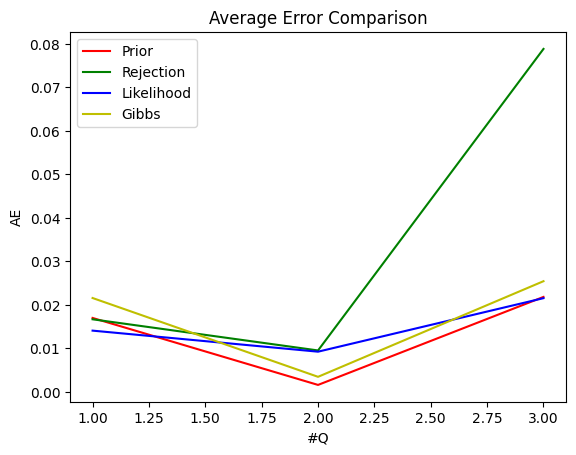

In [330]:
cpts, graph, V = load_model(IN_PATH + "\model.txt")
queries, evidences = read_queries(IN_PATH + "\queries.txt")
print("cpts :",cpts)
print("graph :",graph)
print("V :",V)
print("Queries :",queries)
print("Evidences :",evidences)

prior_ae_vals = []
rejection_ae_vals = []
likelihood_ae_vals = []
gibbs_ae_vals = []

for i in range(len(queries)):
    exact_val = exact_inference(queries[i], evidences[i], cpts, graph)
    # print (exact_val)
    prior = prior_sample(queries[i], evidences[i], cpts, graph, 10000)
    rejection = rejection_sample(queries[i], evidences[i], cpts, graph, 10000)
    likelihood = likelihood_sample(queries[i], evidences[i], cpts, graph, 10000)
    gibbs = gibbs_sample(queries[i], evidences[i], cpts, graph, 10000)
    ############ Start your code #################
    # Add the desirable AE(Average Error) to the corresponding list for each method
    # Replace 'None' with the correct statement
    # Calculate the Average Error for each method and add to the corresponding list
    prior_ae_vals.append(abs(prior - exact_val))
    rejection_ae_vals.append(abs(rejection - exact_val))
    likelihood_ae_vals.append(abs(likelihood - exact_val))
    gibbs_ae_vals.append(abs(gibbs - exact_val))

# Calculate the overall mean Average Error for each method
print("prior: ", prior_ae_vals)
print("rejection: ", rejection_ae_vals)
print("likelihood: ", likelihood_ae_vals)
print("gibbs: ", gibbs_ae_vals)
draw_plot(prior_ae_vals, rejection_ae_vals, likelihood_ae_vals, gibbs_ae_vals, "Average Error Comparison")

# Illustrate the AE of each method with the draw_plot function and save the result in OUT_PATH directory
# None

########### End of your code ############